# Hyperparameter optimization

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import seaborn as sns
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from sklearn.metrics import mean_squared_error

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


## The Network

In [11]:
def initialize_weights(m):
    """ Initializes weights for network

    Args:
        m (pytorch object): A layer in the network
    """
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.LSTM):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


In the code below, you can pick another model from model_structures.py to optimize for.
The code loads the network structure and tests that it works on random data

In [12]:
from model_structures import *
choice_of_model = "best_RNN"     # <- pick another model here if you want
net = best_RNN()                 # <- pick another model here if you want
print("Number of parameters in model:", get_n_params(net))
# sys.exit(1)
print(net)

peptide_random = np.random.normal(0,1, (10, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))
print(binding_random.shape)
output = net(peptide_random,HLA_random)
print(output)

Number of parameters in model: 392801
best_RNN(
  (peptide_encoding): LSTM(12, 10, batch_first=True, bidirectional=True)
  (hla_encoding): LSTM(12, 10, batch_first=True, bidirectional=True)
  (drop_out): Dropout(p=0.4, inplace=False)
  (L_in): Linear(in_features=880, out_features=440, bias=True)
  (batchnorm1): BatchNorm1d(440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L_2): Linear(in_features=440, out_features=1, bias=True)
)
torch.Size([10, 1])
tensor([[0.4964],
        [0.4692],
        [0.4135],
        [0.3431],
        [0.4484],
        [0.5653],
        [0.4866],
        [0.6715],
        [0.2421],
        [0.4900]], grad_fn=<SigmoidBackward0>)


## Functions for loading and encoding data

In encode_dataset() the reader should choose which encoding scheme should be used. Choose by removing the #

In [13]:
def encode_peptide_onehot(aa_seq):
    """Enocding an aa-seqquence using the One-hot scheme

    Args:
        aa_seq (str): Peptide sequence to encode

    Returns:
        np.array: Encoded peptide
    """
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V', 'X']
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []

    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(len(amino_acids))]))
        else:
            try:    
                encoded_aa_seq.append(one_hot_matrix.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)
    return encoded_aa_seq


def load_blossum62_matrix():
    """Loads the blossum62 substitution matrix using the BioPython library

    Returns:
        pd.DataFrame: A pandas dataframe which holds the blossum62 sub-matrix
    """
    from Bio.Align import substitution_matrices
    blosum62 = substitution_matrices.load("BLOSUM62")
    blossum_aas = list("ARNDCQEGHILKMFPSTWYVBZX*")
    blosum62 = pd.DataFrame(blosum62,columns=blossum_aas,index=blossum_aas)
    return blosum62


def encode_peptide_blossum65(aa_seq,blussom_matrix):
    """Enocding an aa-seqquence using the Blossum62 encoding scheme

    Args:
        aa_seq (str): The aa-sequence we want to encode
        blussom_matrix (pd.DataFrame): A pandas dataframe which holds the blossum62 sub-matrix

    Returns:
        np.array: The encoded peptide sequence
    """
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    AAs = blussom_matrix.shape[1]
    for aa in aa_seq:
        if aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(AAs)]))
        else:
            try:
                encoded_aa_seq.append(blussom_matrix.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)

    return encoded_aa_seq


def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    """Enocding an aa-seqquence using the AAindex encoding scheme.

    Args:
        aa_seq (str): The aa-sequence we want to encode
        aaindex_PCA (pd.DataFrame):  A pandas dataframe which holds the AAindex encoding scheme

    Returns:
        np.array: The encoded peptide sequence
    """
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_multiple(aa_seq,aaindex_PCA,blussom_matrix):
    """Enocding an aa-seqquence using the the Combined encoding schemes of AAindex, Blossum62 and One-hot.

    Args:
        aa_seq (str): The aa-sequence we want to encode
        aaindex_PCA (pd.DataFrame):  A pandas dataframe which holds the AAindex encoding scheme
        blussom_matrix (pd.DataFrame):  A pandas dataframe which holds the blossum62 sub-matrix

    Returns:
        np.array: The encoded peptide sequence
    """
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V']
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []


    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(56)]))
        else:
            try:
                aa_index_encoding = aaindex_PCA.loc[aa].to_numpy()
                blossum_encoding = blussom_matrix.loc[aa].to_numpy()
                onehot_encoding = one_hot_matrix.loc[aa].to_numpy()
                encoding = np.concatenate((aa_index_encoding,blossum_encoding,onehot_encoding))
                encoded_aa_seq.append(encoding)

            except KeyError:
                print("Encoding error")
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aa_index_matrix,blosum62_matrix,HLA_dict,peptide_len,padding="right"):
    """Encodes the filtered, balanced and partioned dataset. This is done in three major steps. 
    1) The MHCI-allele code is converted to the paratope sequence. 
    2) The MHCI is encoded using one of four different schemes.
    3) The peptide sequence is encoded using one of four different schemes.
    4) The peptide sequence is padded to a specified length.
    5) Encoding the binding score retrived from netMHCpan
    6) The output label y is created based on the number of positive subjects from the raw data
        1 ~ If number of positive subjects is greater than 0
        0 ~ If number of positive subjects is equal to 0
    

    Args:
        df (pd.Dataframe): The dataframe containing the dataset which is to be encoded
        aa_index_matrix (pd.DataFrame): A pandas dataframe which holds the AAindex encoding scheme
        blussom_matrix (pd.DataFrame):  A pandas dataframe which holds the blossum62 sub-matrix
        HLA_dict (dict): A dictionary used to translate the MHCI-allele code is converted to the paratope sequence. 
        peptide_len (int): The length we want the encoded sequence to have.
        padding (str, optional): The strategy used to pad the peptide sequences. Defaults to "right".

    Returns:
        np.array: Encoded peptide
        np.array: Encoded HLA
        np.array: Encoded Binding-score
        np.array: Encoded Labels

    """
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aa_index_matrix,row)
        # encoded_peptide = encode_peptide_onehot(peptide)
        # encoded_peptide = encode_peptide_blossum65(peptide,blosum62_matrix)
        # encoded_peptide = encode_multiple(peptide,aaindex_PCA,blosum62_matrix)
        

        binding_score = row['binding_score']

        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aa_index_matrix,row)
        # encoded_HLA = encode_peptide_onehot(HLA)
        # encoded_HLA = encode_peptide_blossum65(HLA,blosum62_matrix)
        # encoded_HLA = encode_multiple(HLA,aaindex_PCA,blosum62_matrix)


        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32').reshape(-1,1)
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32').reshape(-1,1)
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Functions for plotting model statistics

In [14]:

def pick_optimal_threshold_auc(fpr, tpr, threshold):
    """Picks the optimal threshold for determining 
    immunogenic/non-immunogenic targets on unlabelled data

    Args:
        fpr (float): false positive rate  
        tpr (float): true positive rate
        threshold (float): The current threshold to update

    Returns:
        int: position of highest geometric mean
    """
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    return ix


def calculate_roc_auc(valid_losses, predictions, targets):
    """calculate the roc auc

    Args:
        valid_losses (list): list of loss on validation set
        targets (list): list of target values for given epoch
        predictions (list): list of model predictions for given epoch

    Returns:
        float: the roc auc value
    """
    best_epoch_model = np.argmin(valid_losses)
    fpr, tpr, threshold = metrics.roc_curve(targets[best_epoch_model],predictions[best_epoch_model])
    roc_auc = round(metrics.auc(fpr,tpr),3)
    return roc_auc


def calculate_pr_auc(valid_losses, predictions, targets):
    """calculate the pr auc

    Args:
        valid_losses (list): list of loss on validation set
        targets (list): list of target values for given epoch
        predictions (list): list of model predictions for given epoch

    Returns:
        float: the pr auc value
    """
    best_epoch_model = np.argmin(valid_losses)
    precision, recall, thresholds = metrics.precision_recall_curve(targets[best_epoch_model], predictions[best_epoch_model])
    pr_auc = round(metrics.auc(recall, precision),3)
    return pr_auc


def plot_test_roc_auc(lst_test_predictions,lst_test_labels):
    """plot test roc auc curve

    Args:
        lst_test_predictions (list): list of model predictions on test data
        lst_test_labels (list): list of targets from test data
    """
    fig = plt.figure()
    plt.title('ROC - {}'.format(choice_of_model))
    fpr, tpr, threshold = metrics.roc_curve(lst_test_labels,lst_test_predictions)
    roc_auc = round(metrics.auc(fpr,tpr),3)
    best_threshold = pick_optimal_threshold_auc(fpr, tpr, threshold)
    plt.plot(fpr, tpr,label = f'AUC {roc_auc}')
    plt.plot(fpr[best_threshold], tpr[best_threshold],color="black",marker="d")
    plt.plot()

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("../plots/{}_test_roc_auc.png".format(choice_of_model), dpi = 300)
    plt.show()

def plot_test_pr_auc(lst_test_predictions,lst_test_labels):
    """plot test pr auc curve

    Args:
        lst_test_predictions (list): list of model predictions on test data
        lst_test_labels (list): list of targets from test data
    """
    fig = plt.figure()
    plt.title('PRC - {}'.format(choice_of_model))
    precision, recall, thresholds = metrics.precision_recall_curve(lst_test_labels, lst_test_predictions)
    roc_auc = round(metrics.auc(recall, precision),3)
    plt.plot(recall, precision,label = f'AUC {roc_auc}')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.savefig("../plots/{}_test_pr_auc.png".format(choice_of_model), dpi = 300)
    plt.show()



## Functions for training the models

In [15]:
def plot_learning_curve(train_accuracies,val_accuracies):
    """Plot accuracy during training

    Args:
        train_accuracies (list): list of training accuracies on target values in current CV fold
        val_accuracies (list): list of validation accuracies on target values in current CV fold
    """
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')


def validation(model,device,valid_loaders,train_loaders):
    """Generates model predictions on train and validation data

    Args:
        model (pytorch model): trained neural network 
        device (state): either cuda enabled or not
        valid_loaders (Data loader): Data loader for validation data
        train_loaders (Data loader): Data loader for training data

    Returns:
        lists: lists of predictions, targets and validation loss
    """
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_predictions = []
        all_train_targets = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i].to(device)
            train_HLA = HLA_train_loader[i].to(device)
            train_labels = label_train_loader[i].to(device)
            train_binding_scores = binding_score_train_loader[i].to(device)
            outputs = model(train_peptides,train_HLA)
            all_train_predictions += outputs.cpu().numpy().tolist()
            all_train_targets += train_labels.cpu().numpy().tolist()
        
        all_val_targets = []
        all_val_predictions = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j].to(device)
            val_HLA = HLA_val_loader[j].to(device)
            val_labels = label_val_loader[j].to(device)
            val_binding_scores = binding_score_val_loader[j].to(device)
            outputs = model(val_peptides,val_HLA)
            all_val_predictions += outputs.cpu().numpy().tolist()
            all_val_targets += val_labels.cpu().numpy().tolist()

        validation_loss = mean_squared_error(all_val_targets,all_val_predictions)

    return all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss


def train(model, device, epochs, train_loaders, valid_loaders, learning_rate, weight_decay):
    """train the model 

    Args:
        model (pytorch model): untrained neural network
        device (state): cuda enabled or not
        epochs (int): number of epoch to do
        train_loaders (Data loaders): Data loaders for training data
        valid_loaders (Data loaders): Data loaders for validation data
        test_loaders (Data loaders): Data loaders for test data
        learning_rate (float) : learning rate value
        weight_decay (float) : weight decay value

    Returns:
        pytorch model: trained neural network
        lists: train and validation losses
    """
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early stopping
    the_last_loss = 100
    patience = 4
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []

    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index].to(device)
            train_HLA = HLA_train_loader[train_batch_index].to(device)
            train_labels = label_train_loader[train_batch_index].to(device)
            train_binding_scores = binding_score_train_loader[train_batch_index].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        train_losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss = validation(model,device,valid_loaders,train_loaders)
        val_losses.append(validation_loss)
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_val_predictions)

        #if epoch % 1 == 0:
         #   print("Epoch %2i : Train Loss %f , Validation loss %f" % (epoch+1, train_losses[-1], val_losses[-1]))
        

        # Early stopping
        the_current_val_loss = val_losses[-1]
        the_last_val_loss = 0 if len(val_losses) < 2 else val_losses[-2]

        if the_current_val_loss > the_last_val_loss:
            trigger_times += 1


            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch

        else:
            trigger_times = 0

    return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)


Device state: cpu


## Encoding entire data set

In [16]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)

blosum62 = load_blossum62_matrix()
blosum62 = (blosum62-blosum62.mean())/blosum62.std()

hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
# hla_database = pd.read_csv('../data/MHC_full.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/ifng_true_balanced_w_parts_w_binding_scores_w_iedb.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Sampling only the HLA-A*02:01 and 9-mers
# all_data["peptide_len"] = all_data["peptide"].apply(len)
# all_data = all_data[(all_data["HLA_allele"] == "HLA-A*02:01") & (all_data["peptide_len"] == 9)]

print("## Encoding dataset")
# AAindex Encoding
all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,blosum62,hla_dic,peptide_len=10,padding="right")

print("Shape of peptides",all_peptides_encoded.shape)
print("Shape of hla",all_HLA_encoded.shape)
print("Shape of binding_scores",all_binding_scores_encoded.shape)

## Encoding dataset
Shape of peptides (3228, 10, 12)
Shape of hla (3228, 34, 12)
Shape of binding_scores (3228, 1)


## Hyperparameter optimization loop

Pick number of random searches to do by changing the size of the loop

In [17]:
N = len(all_data)
no_epoch = 50
testing = True
lst_train_accuracies = []

lst_val_losses = []
lst_val_predictions = []
lst_val_labels = []

lst_test_targets = []
lst_test_predictions = []

lst_batch_size = []
lst_learning_rate = []
lst_weight_decay = []
lst_dropout = []
lst_rnn_encoding = []


lst_roc_auc = []
lst_pr_auc = []

best_roc_auc_indx = 0
best_roc_auc = 0

N_picks = 1 # <- Pick number of random searches to make 

for i in range(N_picks):   
    print("Simulation {}".format(i))

    batch_size = int(random.sample(range(20,100,20),1)[0])
    learning_rate = 1 * 10 ** -int(random.uniform(2,6))
    weight_decay = 1 * 10 ** -int(random.uniform(2,6))
    dropout = random.sample([x/10 for x in range(1,5,1)],1)[0]
    RNN_encodings = random.randint(10,30)


    ## The partitions to use for training, validation ##
    test_parts = [0]
    validation_parts = [1]
    training_parts = [j for j in range(2,10)]

    train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
    train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
    train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
    train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]

    val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
    val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
    val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
    val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]

    test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(test_parts)]
    test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(test_parts)]
    test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(test_parts)]
    test_label_encoded = all_label_encoded[all_data["parts"].isin(test_parts)]

    ## Batches for training the model ##
    peptide_train_loader = list(DataLoader(train_peptides_encoded,batch_size=batch_size))
    HLA_train_loader = list(DataLoader(train_HLA_encoded,batch_size=batch_size))
    binding_score_train_loader = list(DataLoader(train_binding_scores_encoded,batch_size=batch_size))
    label_train_loader = list(DataLoader(train_label_encoded,batch_size=batch_size))

    peptide_val_loader = list(DataLoader(val_peptides_encoded,batch_size=batch_size))
    HLA_val_loader = list(DataLoader(val_HLA_encoded,batch_size=batch_size))
    binding_score_val_loader = list(DataLoader(val_binding_scores_encoded,batch_size=batch_size))
    label_val_loader = list(DataLoader(val_label_encoded,batch_size=batch_size))

    peptide_test_loader = list(DataLoader(test_peptides_encoded,batch_size=len(test_label_encoded)))
    HLA_test_loader = list(DataLoader(test_HLA_encoded,batch_size=len(test_label_encoded)))
    binding_score_test_loader = list(DataLoader(test_binding_scores_encoded,batch_size=len(test_label_encoded)))
    label_test_loader = list(DataLoader(test_label_encoded,batch_size=len(test_label_encoded)))

    train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
    val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)

    torch.manual_seed(0)
    net = best_CNN()
    net.apply(initialize_weights)

    trained_model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch= train(net,device,no_epoch,train_loaders,val_loaders, learning_rate, weight_decay)

    trained_model.eval()
    with torch.no_grad():
        test_peptides = peptide_test_loader[0].to(device)
        test_HLA = HLA_test_loader[0].to(device)
        test_labels = label_test_loader[0].to(device)
        test_binding_scores = binding_score_test_loader[0].to(device)
        outputs = trained_model(test_peptides,test_HLA)
        lst_test_predictions.append(outputs.cpu().numpy().tolist())
        lst_test_targets.append(test_labels.cpu().numpy().tolist())

    lst_train_accuracies.append(train_losses)
    lst_val_losses.append(val_losses)
    lst_val_labels.append(all_val_targets_pr_epoch)
    lst_val_predictions.append(all_val_predictions_pr_epoch)

    lst_batch_size.append(batch_size)
    lst_learning_rate.append(learning_rate)
    lst_weight_decay.append(weight_decay)
    lst_dropout.append(dropout)
    lst_rnn_encoding.append(RNN_encodings)

    roc_auc = calculate_roc_auc(lst_val_losses[i],lst_val_predictions[i],lst_val_labels[i])
    pr_auc = calculate_pr_auc(lst_val_losses[i],lst_val_predictions[i],lst_val_labels[i])
    lst_roc_auc.append(roc_auc)
    lst_pr_auc.append(pr_auc)   

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_roc_auc_indx = i 

Simulation 0


Here, we print the results of which parametervalues to use for the model 

The best round was: 0
The batch size there was 80
The learning rate was 1e-05
The weight decay was 0.001
The dropout rate was 0.3
The RNN-ecnoding was 26
The validation roc auc was 0.704
The validation pr auc was 0.682
[0.704]
1


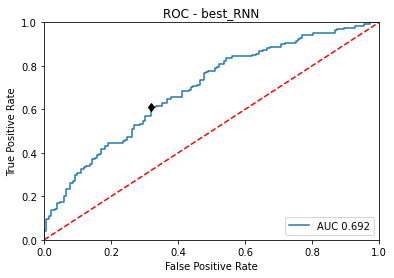

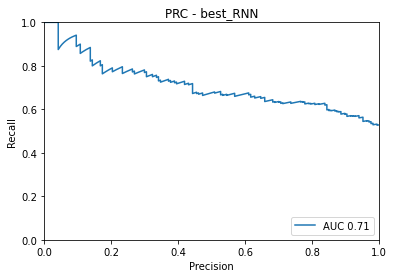

In [18]:
print("The best round was: {}".format(best_roc_auc_indx))
print("The batch size there was {}".format(lst_batch_size[best_roc_auc_indx]))
print("The learning rate was {}".format(lst_learning_rate[best_roc_auc_indx]))
print("The weight decay was {}".format(lst_weight_decay[best_roc_auc_indx]))
print("The dropout rate was {}".format(lst_dropout[best_roc_auc_indx]))
print("The RNN-ecnoding was {}".format(lst_rnn_encoding[best_roc_auc_indx]))


print("The validation roc auc was {}".format(lst_roc_auc[best_roc_auc_indx]))
print("The validation pr auc was {}".format(lst_pr_auc[best_roc_auc_indx]))


print(lst_roc_auc)

print(len(lst_test_predictions))
plot_test_roc_auc(lst_test_predictions[best_roc_auc_indx],lst_test_targets[best_roc_auc_indx])
plot_test_pr_auc(lst_test_predictions[best_roc_auc_indx],lst_test_targets[best_roc_auc_indx])